In [23]:
# Alle Variablen löschen ohne zu fragen.
# Hierdurch werden Seiteneffekte vermieden.
%reset -f

In [24]:
%matplotlib notebook

# Laden der verwendeten Bibliotheken
from PIL import Image
import   numpy  as np               
import   scipy 
import   matplotlib                 # https://matplotlib.org/3.1.1/tutorials/index.html
import   matplotlib.pyplot as plt   # https://matplotlib.org/tutorials/introductory/pyplot.html
import   time

In [25]:
# Bild laden mit PIL
img = Image.open("kalib.bmp").convert("L")

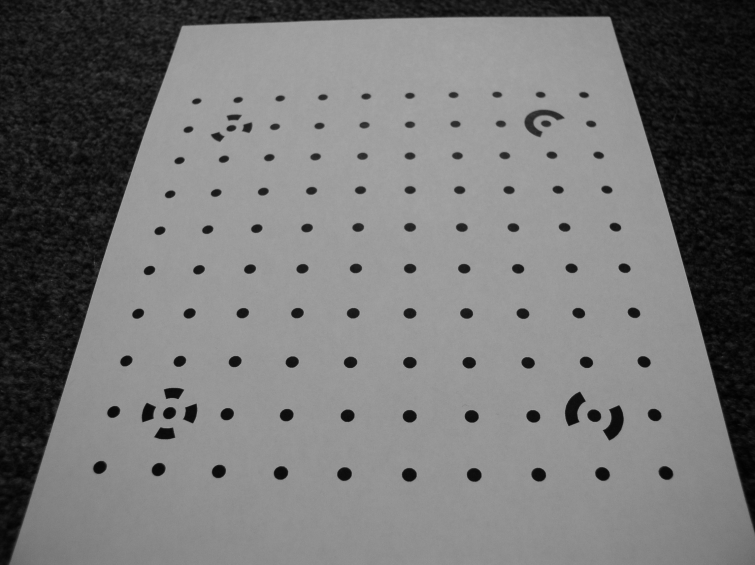

In [26]:
# PIL-Image darstellen
img

In [27]:
# Informationen über PIL-Image
print('format =', img.format)
print('info   =', img.info)
print()
print('size   =', img.size,)
print('mode   =', img.mode)  # 'L' = 8-bit-unsigned

format = None
info   = {'dpi': (72, 72), 'compression': 0}

size   = (755, 565)
mode   = L


In [28]:
# PIL-Image in ein numpy-Array umwandeln
src = np.array(img)
src

array([[ 19,  25,  23, ...,  12,  11,  11],
       [ 17,  19,  20, ...,  11,  11,  10],
       [ 21,  18,  18, ...,  14,  14,  12],
       ...,
       [ 18,  18,  17, ..., 108, 107, 107],
       [ 21,  20,  18, ..., 106, 109, 108],
       [ 21,  20,  18, ..., 107, 110, 108]], dtype=uint8)

In [29]:
# Informationen über numpy-Array
print('shape =', src.shape)
print('type  =', src.dtype)
print('min   =', src.min())
print('max   =', src.max())

shape = (565, 755)
type  = uint8
min   = 1
max   = 166


In [30]:
def outsideImage(coordinate, maxsize):

    isOutside = False;
    
    if (coordinate < 0 or coordinate > maxsize):
        isOutside = True;

    return isOutside



def bilinInterpol(Xtilde, Ytilde, src):
    xfloor = np.int(np.floor(Xtilde))
    yfloor = np.int(np.floor(Ytilde))
    
    xrint = xfloor + 1
    yrint = yfloor + 1
    
    # Alle Bildpunkte
    x1 = np.int64(src[yfloor][xfloor])
    x2 = np.int64(src[yfloor][xrint])
    x3 = np.int64(src[yrint][xfloor])
    x4 = np.int64(src[yrint][xrint])
    
    # interpolierten Grauwert berechnen
    fx1 = x1 + (Xtilde - xfloor) * (x2 - x1)
    fx2 = x3 + (Xtilde - xfloor) * (x4 - x3)   
    interpolatedValue = fx1 + (Ytilde - yfloor) * (fx2 - fx1)
   
    return interpolatedValue

# eckp = [((x1, y1) .... (x4, y4))]
def VierPunkteTransformation(src, eckp, method=0):
    
    # Zielbild anlegen
    dst = np.copy(src)

    # Größe des Quellbildes bestimmen
    ysize = src.shape[0]
    xsize = src.shape[1]
    
    for y in range(0, ysize):
        for x in range(0, xsize):
            # Zielkoordinate normieren
            xNorm = x/xsize
            yNorm = y/ysize
            
            # Hilfsgrößen ausrechnen
            phi1 = (1 - xNorm) * (1 - yNorm)
            phi2 = xNorm * (1 - yNorm)
            phi3 = xNorm * yNorm
            phi4 = (1 - xNorm) * yNorm
            
            # Quellkoordinate bestimmen
            xq = phi1 * eckp[0][0] + phi2 * eckp[1][0] + phi3 * eckp[2][0] + phi4 * eckp[3][0] 
            yq = phi1 * eckp[0][1] + phi2 * eckp[1][1] + phi3 * eckp[2][1] + phi4 * eckp[3][1] 
            
            if(outsideImage(xq, xsize) or outsideImage(yq, ysize)):
                dst[y][x] = 0        
            elif (method == 1):
                interpolatedValue = bilinInterpol(xq, yq, src)
                
                # Quellbildpunkt übertragen
                dst[y][x] = interpolatedValue
            else:
                # Kaufmännisch runden
                xq += 0.5
                yq += 0.5
                xq = np.int(xq)
                yq = np.int(yq)
                
                # Quellbildpunkt übertragen
                dst[y][x] = src[yq][xq]
      
    return dst





In [31]:
start = time.time()

# Eckpunkt-Array anlegen
# eckp = [((x1, y1) .... (x4, y4))]
eckp = [(196, 100), (583, 95), (666, 471), (100, 466)]
# Transformation aufrufen
Transformed = VierPunkteTransformation(src, eckp, method=0)

ende   = time.time()
print('Runtime   = {:5.3f}s'.format(ende-start))

Runtime   = 1.254s


<IPython.core.display.Javascript object>


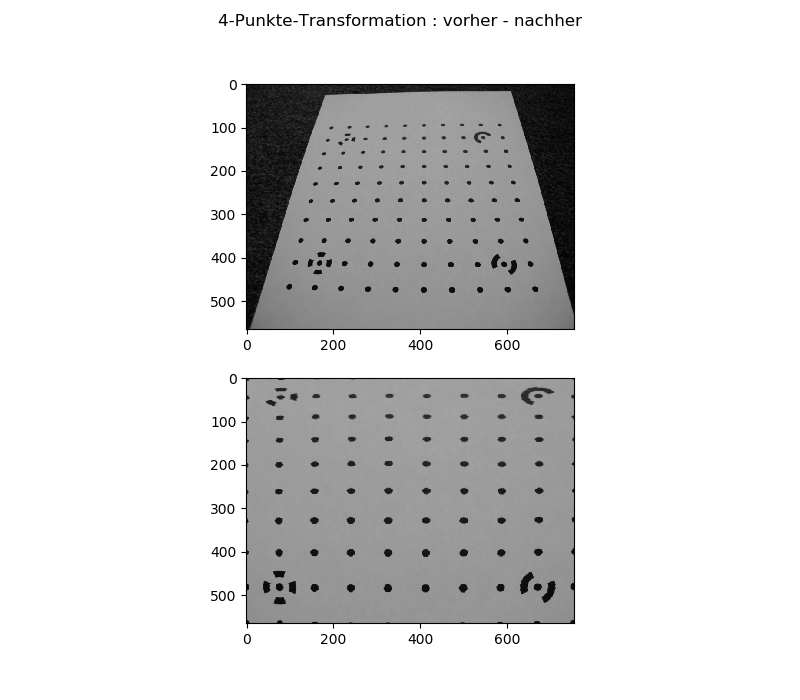

min/max = 9 166
shape   = (565, 755)
dtype   = uint8


In [32]:
plt.figure(figsize = (8,7))

plt.subplot(211)
plt.imshow(src, cmap='gray', vmin=0, vmax=255)
plt.subplot(212)
plt.imshow(Transformed, cmap='gray', vmin=0, vmax=255)
plt.suptitle('4-Punkte-Transformation : vorher - nachher')
plt.show()

#plt.imshow(Transformed, cmap='gray', vmin=0, vmax=255)
#plt.title('affine Transformation : vorher - nachher')
#plt.show()

# Informationen zum Bild
print('min/max =', Transformed.min(), Transformed.max())
print('shape   =', Transformed.shape)
print('dtype   =', Transformed.dtype)

In [11]:
# Liste der Variablen ausgeben
%whos    

Variable                   Type        Data/Info
------------------------------------------------
Image                      module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
Transformed                ndarray     565x755: 426575 elems, type `uint8`, 426575 bytes (416.5771484375 kb)
VierPunkteTransformation   function    <function VierPunkteTrans<...>on at 0x000002587FE9EC18>
bilinInterpol              function    <function bilinInterpol at 0x000002587CDBE8B8>
eckp                       list        n=4
ende                       float       1587998400.170173
img                        Image       <PIL.Image.Image image mo<...>755x565 at 0x2587BFCCC08>
matplotlib                 module      <module 'matplotlib' from<...>matplotlib\\__init__.py'>
np                         module      <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
outsideImage               function    <function outsideImage at 0x000002587CDBE5E8>
plt                        module      <module 